# Initialize

In [2]:
%matplotlib inline
import yt
import yt.fields.vector_operations
from yt.units import dimensions, kboltz, mp
import os, sys, glob, errno
import matplotlib as mpl
#mpl.use("agg")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import Locator
from scipy.interpolate import spline
import operator
import h5py
import mag_initialize as m


mu = 0.588
mu_e = 1.14
gamma = 5/3

a=0

def get_units(L):
    temp_str = str(L[-1:])
    k = temp_str.rfind("]") + 2
    return temp_str[k:]

def density(filename,groupname):
    return m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/density_mean"%groupname)[a:]  

def kT(filename,groupname):
    return m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/kT_mean"%groupname)[a:] 

# radial 
def velocity_r_variance(filename,groupname):
    v_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_stddev"%groupname)[a:] 
    return v_r_stddev**2

# tangential
def velocity_t_variance(filename,groupname):
    v_theta_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_stddev"%groupname)[a:] 
    v_phi_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_stddev"%groupname)[a:]  
    return v_theta_stddev**2+v_phi_stddev**2

# filename is HDF5 file, groupname is 0500_profiles
def velocity_variance(filename,groupname):
    #v_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_stddev"%groupname)
    #v_t_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_stddev"%groupname)
    #v_p_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_stddev"%groupname)    
    return velocity_r_variance(filename,groupname)+velocity_t_variance(filename,groupname)

# filename is HDF5 file, groupname is 0500_profiles
def mag_field_variance(filename,groupname):
    B_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_radius_stddev"%groupname)[a:] 
    B_t_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_theta_stddev"%groupname)[a:] 
    B_p_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_phi_stddev"%groupname)[a:]     
    return B_r_stddev**2+B_t_stddev**2+B_p_stddev**2

# mean squared
def velocity_mean_sq(filename,groupname):
    v_r_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_mean"%groupname)[a:] 
    v_t_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_mean"%groupname)[a:] 
    v_p_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_mean"%groupname)[a:]     
    return v_r_mean**2+v_t_mean**2+v_p_mean**2

# mean squared
def mag_field_mean_sq(filename,groupname):
    B_r_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_radius_mean"%groupname)[a:] 
    B_t_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_theta_mean"%groupname)[a:] 
    B_p_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_phi_mean"%groupname)[a:]     
    return B_r_mean**2+B_t_mean**2+B_p_mean**2

# sound speed sq
def c_s_sq(filename,groupname):
    return gamma*kT(filename,groupname)/(mu*mp)

# Alfven speed sq
def v_A_sq(filename,groupname):
    return (mag_field_variance(filename,groupname)+mag_field_mean_sq(filename,groupname))/(4*np.pi*density(filename,groupname))
    
def n_e(filename,groupname):
    return density(filename,groupname)/(mu_e*mp)
    
def S(filename,groupname):
    return kT(filename,groupname)/(n_e(filename,groupname))**(2/3)

def hopefully_constant(filename,groupname):
    B_sq = (mag_field_variance(filename,groupname)+mag_field_mean_sq(filename,groupname))
    return B_sq/(density(filename,groupname))**(4/3)

# Density Plots

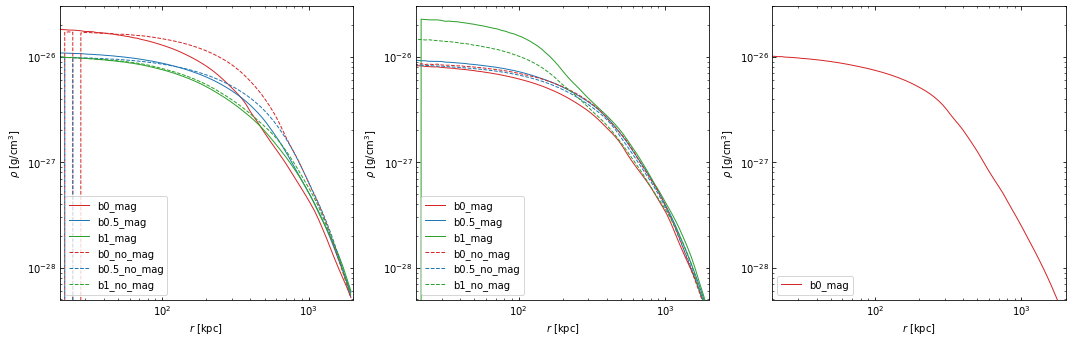

In [13]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

a=0

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=5e-29
ylim2=3e-26
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, density(SIM_TYPE11_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, density(SIM_TYPE12_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, density(SIM_TYPE13_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, density(SIM_TYPE21_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, density(SIM_TYPE22_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
line_23_mag, =ax2.plot(radius, density(SIM_TYPE23_mag,"profiles_0450"), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, density(SIM_TYPE31_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
#line_32_mag, =ax3.plot(radius, density(SIM_TYPE32_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
#line_33_mag, =ax3.plot(radius, density(SIM_TYPE33_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")

# non-magnetic
line_11_no_mag, =ax1.plot(radius, density(SIM_TYPE11_no_mag,"profiles_0500"), 'C3--', lw=1, label="b0_no_mag")
line_12_no_mag, =ax1.plot(radius, density(SIM_TYPE12_no_mag,"profiles_0500"), 'C0--', lw=1, label="b0.5_no_mag")
line_13_no_mag, =ax1.plot(radius, density(SIM_TYPE13_no_mag,"profiles_0500"), 'C2--', lw=1, label="b1_no_mag")
line_21_no_mag, =ax2.plot(radius, density(SIM_TYPE21_no_mag,"profiles_0500"), 'C3--', lw=1, label="b0_no_mag")
line_22_no_mag, =ax2.plot(radius, density(SIM_TYPE22_no_mag,"profiles_0500"), 'C0--', lw=1, label="b0.5_no_mag")
line_23_no_mag, =ax2.plot(radius, density(SIM_TYPE23_no_mag,"profiles_0500"), 'C2--', lw=1, label="b1_no_mag")
#line_31_no_mag, =ax3.plot(radius, density(SIM_TYPE31_no_mag,"profiles_0500"), 'C3--', lw=1, label="b0_no_mag")
#line_32_no_mag, =ax3.plot(radius, density(SIM_TYPE32_no_mag,"profiles_0500"), 'C0--', lw=1, label="b0.5_no_mag")
#line_33_no_mag, =ax3.plot(radius, density(SIM_TYPE33_no_mag,"profiles_0500"), 'C2--', lw=1, label="b1_no_mag")

ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=3)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag,line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=3)
# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=1)
#ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=3)
#ax2.legend(handles=[line_21_mag,line_22_mag,line_21_no_mag], loc=3)
ax3.legend(handles=[line_31_mag], loc=3)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel(r"$\rho$ [g/cm$^3$]") #% get_units(density(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

In [6]:
density(SIM_TYPE11_no_mag,"profiles_0500_80b")

YTArray([  1.72878837e-26,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.71243645e-26,   1.71152519e-26,
         1.70225475e-26,   0.00000000e+00,   1.69169767e-26,
         1.69692182e-26,   1.68310519e-26,   1.67711142e-26,
         1.67382813e-26,   1.66266054e-26,   1.65317662e-26,
         1.63100717e-26,   1.62899532e-26,   1.61994842e-26,
         1.60288177e-26,   1.58420286e-26,   1.56947514e-26,
         1.54692512e-26,   1.52426189e-26,   1.49896546e-26,
         1.47041212e-26,   1.44054366e-26,   1.40808262e-26,
         1.37162739e-26,   1.33426913e-26,   1.29431668e-26,
         1.25126854e-2

# Entropy Plots

/home/jzuhone/Source/yt/yt/units/yt_array.py:1135: RuntimeWarning: invalid value encountered in true_divide
  return super(YTArray, self).__truediv__(ro)


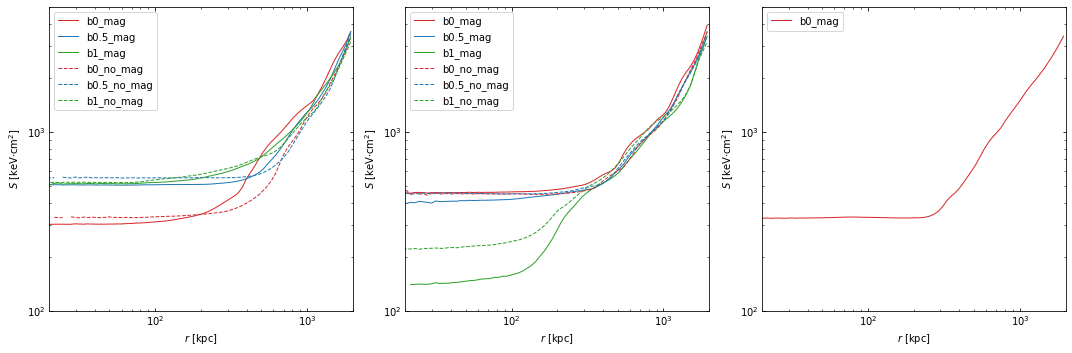

In [5]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e2
ylim2=5e3
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, S(SIM_TYPE11_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, S(SIM_TYPE12_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, S(SIM_TYPE13_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, S(SIM_TYPE21_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, S(SIM_TYPE22_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
line_23_mag, =ax2.plot(radius, S(SIM_TYPE23_mag,"profiles_0450"), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, S(SIM_TYPE31_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
#line_32_mag, =ax3.plot(radius, S(SIM_TYPE32_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
#line_33_mag, =ax3.plot(radius, S(SIM_TYPE33_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")

# non-magnetic
line_11_no_mag, =ax1.plot(radius, S(SIM_TYPE11_no_mag,"profiles_0500"), 'C3--', lw=1, label="b0_no_mag")
line_12_no_mag, =ax1.plot(radius, S(SIM_TYPE12_no_mag,"profiles_0500"), 'C0--', lw=1, label="b0.5_no_mag")
line_13_no_mag, =ax1.plot(radius, S(SIM_TYPE13_no_mag,"profiles_0500"), 'C2--', lw=1, label="b1_no_mag")
line_21_no_mag, =ax2.plot(radius, S(SIM_TYPE21_no_mag,"profiles_0500"), 'C3--', lw=1, label="b0_no_mag")
line_22_no_mag, =ax2.plot(radius, S(SIM_TYPE22_no_mag,"profiles_0500"), 'C0--', lw=1, label="b0.5_no_mag")
line_23_no_mag, =ax2.plot(radius, S(SIM_TYPE23_no_mag,"profiles_0500"), 'C2--', lw=1, label="b1_no_mag")
#line_31_no_mag, =ax3.plot(radius, S(SIM_TYPE31_no_mag,"profiles_0500"), 'C3--', lw=1, label="b0_no_mag")
#line_32_no_mag, =ax3.plot(radius, S(SIM_TYPE32_no_mag,"profiles_0500"), 'C0--', lw=1, label="b0.5_no_mag")
#line_33_no_mag, =ax3.plot(radius, S(SIM_TYPE33_no_mag,"profiles_0500"), 'C2--', lw=1, label="b1_no_mag")

ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=2)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag,line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=2)
# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=1)
#ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=2)
#ax2.legend(handles=[line_21_mag,line_22_mag,line_21_no_mag], loc=2)
ax3.legend(handles=[line_31_mag], loc=2)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')
    
    plot_ax.set_ylabel("$S$ [keV$\cdot$cm$^2$]") #% get_units(S(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

# Velocity Dispersion to Sound Speed Plots

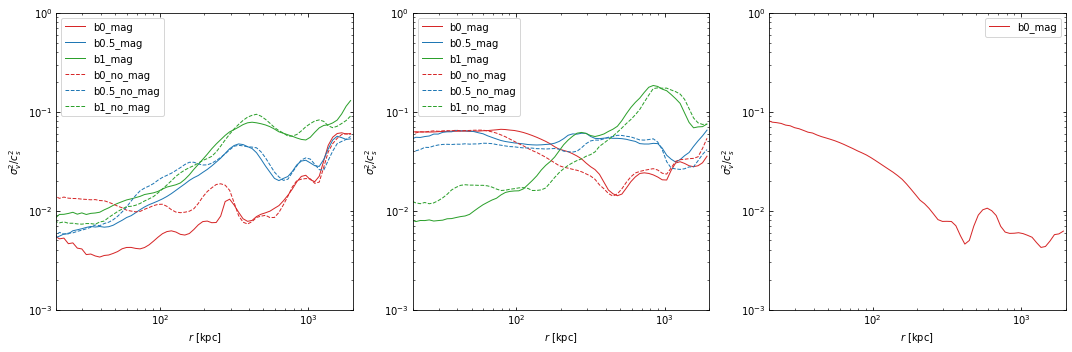

In [7]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e-3
ylim2=1e0
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE11_mag,"profiles_0500")/c_s_sq(SIM_TYPE11_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE12_mag,"profiles_0500")/c_s_sq(SIM_TYPE12_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE13_mag,"profiles_0500")/c_s_sq(SIM_TYPE13_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE21_mag,"profiles_0500")/c_s_sq(SIM_TYPE21_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE22_mag,"profiles_0500")/c_s_sq(SIM_TYPE22_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
line_23_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE23_mag,"profiles_0450")/c_s_sq(SIM_TYPE23_mag,"profiles_0450"), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE31_mag,"profiles_0500")/c_s_sq(SIM_TYPE31_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
#line_32_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE32_mag,"profiles_0500")/c_s_sq(SIM_TYPE32_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
#line_33_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE33_mag,"profiles_0500")/c_s_sq(SIM_TYPE33_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")

# non-magnetic
line_11_no_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE11_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE11_no_mag,"profiles_0500"), 'C3--', lw=1, label="b0_no_mag")
line_12_no_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE12_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE12_no_mag,"profiles_0500"), 'C0--', lw=1, label="b0.5_no_mag")
line_13_no_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE13_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE13_no_mag,"profiles_0500"), 'C2--', lw=1, label="b1_no_mag")
line_21_no_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE21_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE21_no_mag,"profiles_0500"), 'C3--', lw=1, label="b0_no_mag")
line_22_no_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE22_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE22_no_mag,"profiles_0500"), 'C0--', lw=1, label="b0.5_no_mag")
line_23_no_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE23_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE23_no_mag,"profiles_0500"), 'C2--', lw=1, label="b1_no_mag")
#line_31_no_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE31_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE31_no_mag,"profiles_0500"), 'C3--', lw=1, label="b0_no_mag")
#line_32_no_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE32_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE32_no_mag,"profiles_0500"), 'C0--', lw=1, label="b0.5_no_mag")
#line_33_no_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE33_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE33_no_mag,"profiles_0500"), 'C2--', lw=1, label="b1_no_mag")

ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=2)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag,line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=2)
# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=1)
#ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=2)
#ax2.legend(handles=[line_21_mag,line_22_mag,line_21_no_mag], loc=1)
ax3.legend(handles=[line_31_mag], loc=1)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$\sigma_v^2/c_s^2$") #% get_units(velocity_variance(SIM_TYPE11_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE11_no_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

# Alfven Speed to Sound Speed Plots

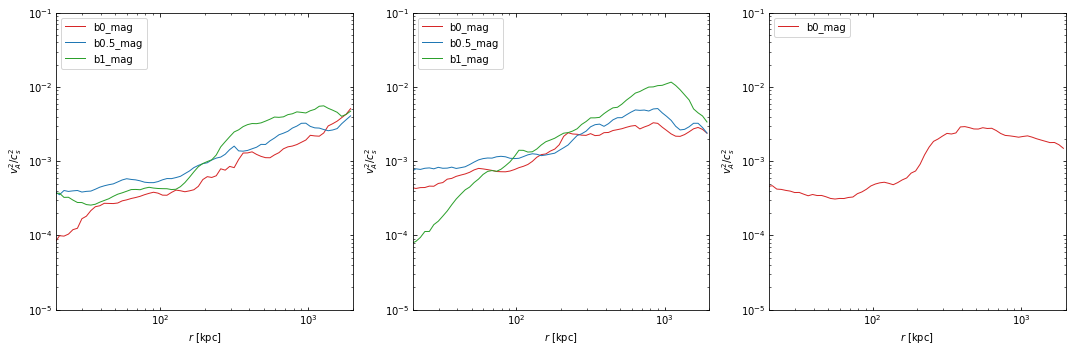

In [8]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e-5
ylim2=1e-1
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, v_A_sq(SIM_TYPE11_mag,"profiles_0500")/c_s_sq(SIM_TYPE11_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, v_A_sq(SIM_TYPE12_mag,"profiles_0500")/c_s_sq(SIM_TYPE12_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, v_A_sq(SIM_TYPE13_mag,"profiles_0500")/c_s_sq(SIM_TYPE13_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, v_A_sq(SIM_TYPE21_mag,"profiles_0500")/c_s_sq(SIM_TYPE21_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, v_A_sq(SIM_TYPE22_mag,"profiles_0500")/c_s_sq(SIM_TYPE22_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
line_23_mag, =ax2.plot(radius, v_A_sq(SIM_TYPE23_mag,"profiles_0450")/c_s_sq(SIM_TYPE23_mag,"profiles_0450"), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, v_A_sq(SIM_TYPE31_mag,"profiles_0500")/c_s_sq(SIM_TYPE31_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
#line_32_mag, =ax3.plot(radius, v_A_sq(SIM_TYPE32_mag,"profiles_0500")/c_s_sq(SIM_TYPE32_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
#line_33_mag, =ax3.plot(radius, v_A_sq(SIM_TYPE33_mag,"profiles_0500")/c_s_sq(SIM_TYPE33_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")

# ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag], loc=1)
# ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=1)
# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=1)
ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag], loc=2)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=2)
ax3.legend(handles=[line_31_mag], loc=2)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$v_A^2/c_s^2$") #% get_units(v_A_sq(SIM_TYPE11_mag,"profiles_0500")/c_s_sq(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

# Velocity Dispersion to Alfven Speed

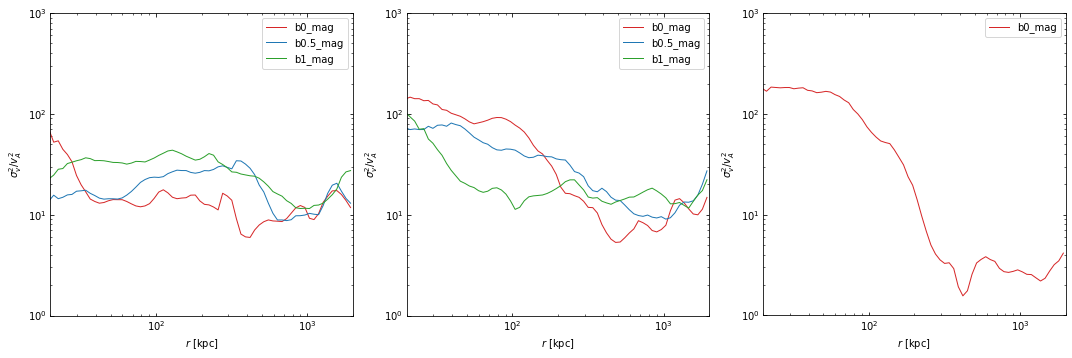

In [9]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e0
ylim2=1e3
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE11_mag,"profiles_0500")/v_A_sq(SIM_TYPE11_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE12_mag,"profiles_0500")/v_A_sq(SIM_TYPE12_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE13_mag,"profiles_0500")/v_A_sq(SIM_TYPE13_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE21_mag,"profiles_0500")/v_A_sq(SIM_TYPE21_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE22_mag,"profiles_0500")/v_A_sq(SIM_TYPE22_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
line_23_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE23_mag,"profiles_0450")/v_A_sq(SIM_TYPE23_mag,"profiles_0450"), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE31_mag,"profiles_0500")/v_A_sq(SIM_TYPE31_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
#line_32_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE32_mag,"profiles_0500")/v_A_sq(SIM_TYPE32_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
#line_33_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE33_mag,"profiles_0500")/v_A_sq(SIM_TYPE33_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")

# ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag], loc=1)
# ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=1)
# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=1)
ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag], loc=1)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=1)
ax3.legend(handles=[line_31_mag], loc=1)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$\sigma_v^2/v_A^2$") #% get_units(velocity_variance(SIM_TYPE11_mag,"profiles_0500")/v_A_sq(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

# kT Plots

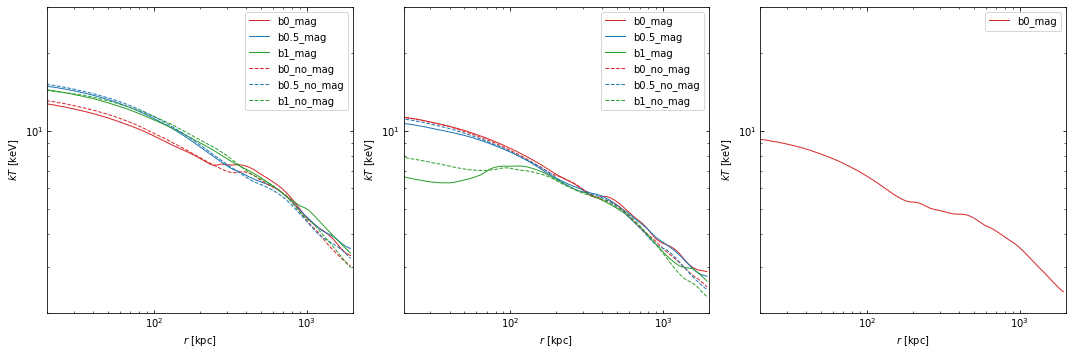

In [10]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=2e0
ylim2=3e1
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, kT(SIM_TYPE11_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, kT(SIM_TYPE12_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, kT(SIM_TYPE13_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, kT(SIM_TYPE21_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, kT(SIM_TYPE22_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
line_23_mag, =ax2.plot(radius, kT(SIM_TYPE23_mag,"profiles_0450"), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, kT(SIM_TYPE31_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
#line_32_mag, =ax3.plot(radius, kT(SIM_TYPE32_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
#line_33_mag, =ax3.plot(radius, kT(SIM_TYPE33_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")

# non-magnetic
line_11_no_mag, =ax1.plot(radius, kT(SIM_TYPE11_no_mag,"profiles_0500"), 'C3--', lw=1, label="b0_no_mag")
line_12_no_mag, =ax1.plot(radius, kT(SIM_TYPE12_no_mag,"profiles_0500"), 'C0--', lw=1, label="b0.5_no_mag")
line_13_no_mag, =ax1.plot(radius, kT(SIM_TYPE13_no_mag,"profiles_0500"), 'C2--', lw=1, label="b1_no_mag")
line_21_no_mag, =ax2.plot(radius, kT(SIM_TYPE21_no_mag,"profiles_0500"), 'C3--', lw=1, label="b0_no_mag")
line_22_no_mag, =ax2.plot(radius, kT(SIM_TYPE22_no_mag,"profiles_0500"), 'C0--', lw=1, label="b0.5_no_mag")
line_23_no_mag, =ax2.plot(radius, kT(SIM_TYPE23_no_mag,"profiles_0500"), 'C2--', lw=1, label="b1_no_mag")
#line_31_no_mag, =ax3.plot(radius, kT(SIM_TYPE31_no_mag,"profiles_0500"), 'C3--', lw=1, label="b0_no_mag")
#line_32_no_mag, =ax3.plot(radius, kT(SIM_TYPE32_no_mag,"profiles_0500"), 'C0--', lw=1, label="b0.5_no_mag")
#line_33_no_mag, =ax3.plot(radius, kT(SIM_TYPE33_no_mag,"profiles_0500"), 'C2--', lw=1, label="b1_no_mag")

ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=1)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag,line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=1)
# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=1)
#ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=1)
#ax2.legend(handles=[line_21_mag,line_22_mag,line_21_no_mag], loc=1)
ax3.legend(handles=[line_31_mag], loc=1)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$kT$ [keV]") #% get_units(kT(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

Que?

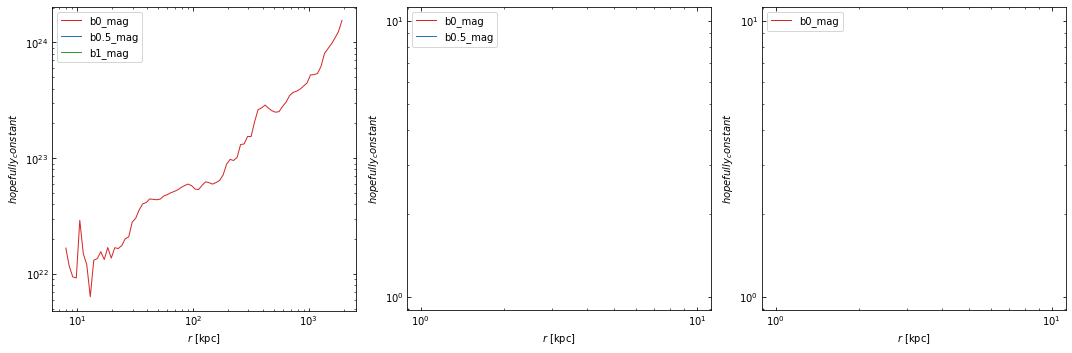

In [11]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

#xlim1=2e1
#xlim2=2e3
#ylim1=1e-5
#ylim2=1e-1
#num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))
num=1

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]



# magnetic
line_11_mag, =ax1.plot(radius, hopefully_constant(SIM_TYPE11_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
#line_12_mag, =ax1.plot(radius, hopefully_constant(SIM_TYPE12_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
#line_13_mag, =ax1.plot(radius, hopefully_constant(SIM_TYPE13_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")
#line_21_mag, =ax2.plot(radius, hopefully_constant(SIM_TYPE21_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
#line_22_mag, =ax2.plot(radius, hopefully_constant(SIM_TYPE22_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
#line_23_mag, =ax2.plot(radius, hopefully_constant(SIM_TYPE23_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")
#line_31_mag, =ax3.plot(radius, hopefully_constant(SIM_TYPE31_mag,"profiles_0500"), 'C3', lw=1, label="b0_mag")
#line_32_mag, =ax3.plot(radius, hopefully_constant(SIM_TYPE32_mag,"profiles_0500"), 'C0', lw=1, label="b0.5_mag")
#line_33_mag, =ax3.plot(radius, hopefully_constant(SIM_TYPE33_mag,"profiles_0500"), 'C2', lw=1, label="b1_mag")

# ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag], loc=1)
# ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=1)
# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=1)
ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag], loc=2)
ax2.legend(handles=[line_21_mag,line_22_mag], loc=2)
ax3.legend(handles=[line_31_mag], loc=2)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$hopefully_constant$") #% get_units(v_A_sq(SIM_TYPE11_mag,"profiles_0500")/c_s_sq(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    #plot_ax.set_xlim(xlim1,xlim2)
    #plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

In [12]:
def hopefully_constant(filename,groupname):
    B_sq = (mag_field_variance(filename,groupname)+mag_field_mean_sq(filename,groupname))
    return B_sq/(density(filename,groupname))**(4/3)

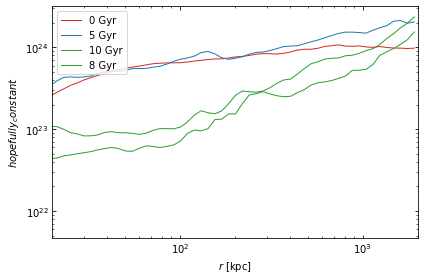

In [13]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0000")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
#m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
#ylim1=1e21
#ylim2=1e25
#num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))
num=1

ax1 = m.plt.subplot(111)
axes=[ax1]

# magnetic
line_11_mag, =ax1.plot(radius, hopefully_constant(SIM_TYPE11_mag,"profiles_0000"), 'C3', lw=1, label="0 Gyr")
line_12_mag, =ax1.plot(radius, hopefully_constant(SIM_TYPE11_mag,"profiles_0250"), 'C0', lw=1, label="5 Gyr")
line_13_mag, =ax1.plot(radius, hopefully_constant(SIM_TYPE11_mag,"profiles_0500"), 'C2', lw=1, label="10 Gyr")
line_14_mag, =ax1.plot(radius, hopefully_constant(SIM_TYPE11_mag,"profiles_0400"), 'C2', lw=1, label="8 Gyr")

#line_21_mag, =ax2.plot(radius, hopefully_constant(SIM_TYPE21_mag,"profiles_0000"), 'C3', lw=1, label="b0_mag")
#line_22_mag, =ax2.plot(radius, hopefully_constant(SIM_TYPE22_mag,"profiles_0000"), 'C0', lw=1, label="b0.5_mag")
#line_23_mag, =ax2.plot(radius, hopefully_constant(SIM_TYPE23_mag,"profiles_0000"), 'C2', lw=1, label="b1_mag")
#line_31_mag, =ax3.plot(radius, hopefully_constant(SIM_TYPE31_mag,"profiles_0000"), 'C3', lw=1, label="b0_mag")
#line_32_mag, =ax3.plot(radius, hopefully_constant(SIM_TYPE32_mag,"profiles_0000"), 'C0', lw=1, label="b0.5_mag")
#line_33_mag, =ax3.plot(radius, hopefully_constant(SIM_TYPE33_mag,"profiles_0000"), 'C2', lw=1, label="b1_mag")

# ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag], loc=1)
# ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=1)
# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=1)
ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_14_mag], loc=2)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$hopefully_constant$") #% get_units(v_A_sq(SIM_TYPE11_mag,"profiles_0000")/c_s_sq(SIM_TYPE11_mag,"profiles_0000")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    #plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

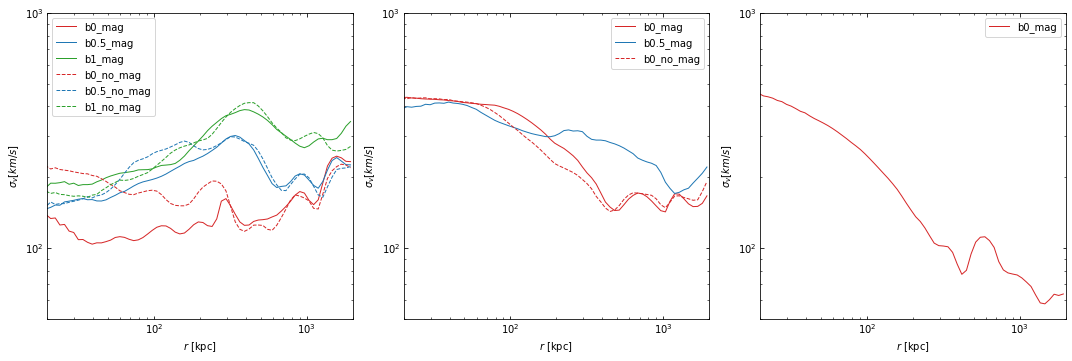

In [14]:
def vel_dispersion(filename,groupname):
    return velocity_variance(filename,groupname)**(1/2)

SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=5e1
ylim2=1e3
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))
#num=1

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, vel_dispersion(SIM_TYPE11_mag,"profiles_0500").in_units('km/s'), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, vel_dispersion(SIM_TYPE12_mag,"profiles_0500").in_units('km/s'), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, vel_dispersion(SIM_TYPE13_mag,"profiles_0500").in_units('km/s'), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, vel_dispersion(SIM_TYPE21_mag,"profiles_0500").in_units('km/s'), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, vel_dispersion(SIM_TYPE22_mag,"profiles_0500").in_units('km/s'), 'C0', lw=1, label="b0.5_mag")
#line_23_mag, =ax2.plot(radius, vel_dispersion(SIM_TYPE23_mag,"profiles_0500").in_units('km/s'), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, vel_dispersion(SIM_TYPE31_mag,"profiles_0500").in_units('km/s'), 'C3', lw=1, label="b0_mag")
#line_32_mag, =ax3.plot(radius, vel_dispersion(SIM_TYPE32_mag,"profiles_0500").in_units('km/s'), 'C0', lw=1, label="b0.5_mag")
#line_33_mag, =ax3.plot(radius, vel_dispersion(SIM_TYPE33_mag,"profiles_0500").in_units('km/s'), 'C2', lw=1, label="b1_mag")

# non-magnetic
line_11_no_mag, =ax1.plot(radius, vel_dispersion(SIM_TYPE11_no_mag,"profiles_0500").in_units('km/s'), 'C3--', lw=1, label="b0_no_mag")
line_12_no_mag, =ax1.plot(radius, vel_dispersion(SIM_TYPE12_no_mag,"profiles_0500").in_units('km/s'), 'C0--', lw=1, label="b0.5_no_mag")
line_13_no_mag, =ax1.plot(radius, vel_dispersion(SIM_TYPE13_no_mag,"profiles_0500").in_units('km/s'), 'C2--', lw=1, label="b1_no_mag")
line_21_no_mag, =ax2.plot(radius, vel_dispersion(SIM_TYPE21_no_mag,"profiles_0500").in_units('km/s'), 'C3--', lw=1, label="b0_no_mag")
#line_22_no_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE22_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE22_no_mag,"profiles_0500"), 'C0--', lw=1, label="b0.5_no_mag")
#line_23_no_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE23_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE23_no_mag,"profiles_0500"), 'C2--', lw=1, label="b1_no_mag")
#line_31_no_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE31_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE31_no_mag,"profiles_0500"), 'C3--', lw=1, label="b0_no_mag")
#line_32_no_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE32_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE32_no_mag,"profiles_0500"), 'C0--', lw=1, label="b0.5_no_mag")
#line_33_no_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE33_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE33_no_mag,"profiles_0500"), 'C2--', lw=1, label="b1_no_mag")

# ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=1)
# ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag,line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=1)
# ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=1)
ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=2)
ax2.legend(handles=[line_21_mag,line_22_mag,line_21_no_mag], loc=1)
ax3.legend(handles=[line_31_mag], loc=1)


#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$\sigma_v [km/s]$") #% get_units(vel_dispersion(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

In [4]:
len(radius)

80

In [14]:
print(density(SIM_TYPE22_mag,"profiles_0500"))

[  9.47950037e-27   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   9.39302381e-27   0.00000000e+00   9.37322201e-27
   0.00000000e+00   0.00000000e+00   9.35142551e-27   9.28832119e-27
   9.28221017e-27   9.30796357e-27   9.23662706e-27   9.25227460e-27
   9.15396166e-27   9.14891841e-27   9.04400635e-27   9.03000291e-27
   9.01952662e-27   9.01915758e-27   8.87941569e-27   8.85899903e-27
   8.79464646e-27   8.72882827e-27   8.67197556e-27   8.61178926e-27
   8.50628395e-27   8.44543559e-27   8.36009333e-27   8.27772518e-27
   8.18750375e-27   8.08689116e-27   7.99735282e-27   7.89190405e-27
   7.78056358e-27   7.65523872e-27   7.52308708e-27   7.39564839e-27
   7.24922578e-27   7.08918331e-27   6.92305329e-27   6.74734112e-27
   6.56934056e-27   6.38003769e-27